In [ ]:
import torch
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.12.1+cu113 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
!pip install --upgrade -q fastai

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Unzipping the provided images
!mkdir -p images
!unzip -q /content/drive/MyDrive/Images.zip -d images

In [ ]:
# Make sure you have all the files ready in colab:
!ls 

drive  images  sample_data


In [ ]:
# Imports - in this case all we need is:
from fastai.vision.all import *

In [ ]:
# Load the provided training data
train = pd.read_csv('/content/Train.csv')
print(train.shape)
train.head()

(5340, 2)


,Image_id,Label
0,id_004wknd7qd.jpg,blast
1,id_004wknd7qd_rgn.jpg,blast
2,id_005sitfgr2.jpg,brown
3,id_005sitfgr2_rgn.jpg,brown
4,id_00stp9t6m6.jpg,blast


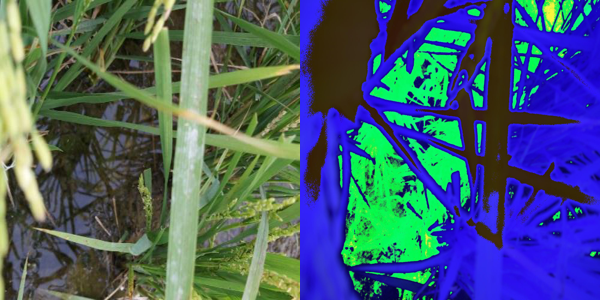

In [ ]:
#markdown View the two images provided for the first training element:
out = Image.new('RGB', (600, 300))
out.paste(Image.open('/content/images/id_004wknd7qd.jpg').resize((300, 300)), (0, 0))
out.paste(Image.open('/content/images/id_004wknd7qd_rgn.jpg').resize((300, 300)), (300, 0))
out

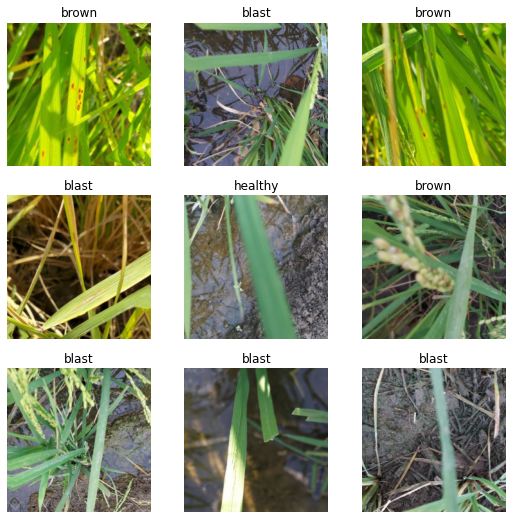

In [ ]:
# Create the dataloaders
train_rgb = train[~train.Image_id.str.contains('_rgn')] # Just the RGB images
dls = ImageDataLoaders.from_df(train_rgb, fn_col='Image_id', label_col='Label', 
                               folder='images', item_tfms=Resize(400),
                               batch_tfms = aug_transforms(size=224))
dls.show_batch() # Note the augmentation applied to the images!

In [ ]:
k=list(np.arange(0.0001,1, 0.001))[:3]

In [ ]:
learn = vision_learner(dls, resnet101, metrics=error_rate, lr=0.0025)
learn.fine_tune(20)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.394418,0.824633,0.267790,00:29


epoch,train_loss,valid_loss,error_rate,time
0,0.788096,0.494012,0.176030,00:39
1,0.597369,0.410730,0.134831,00:39
2,0.453549,0.360536,0.121723,00:40
3,0.353936,0.391599,0.114232,00:39
4,0.307213,0.445786,0.104869,00:39
5,0.245475,0.507880,0.101124,00:39
6,0.208959,0.436735,0.091760,00:39
7,0.177035,0.281841,0.080524,00:39
8,0.134463,0.300203,0.073034,00:39
9,0.107295,0.344258,0.074906,00:39


In [ ]:
# learn = vision_learner(dls, resnet101, metrics=error_rate,lr=0.02, ps=0.5)
# learn.fine_tune(10)

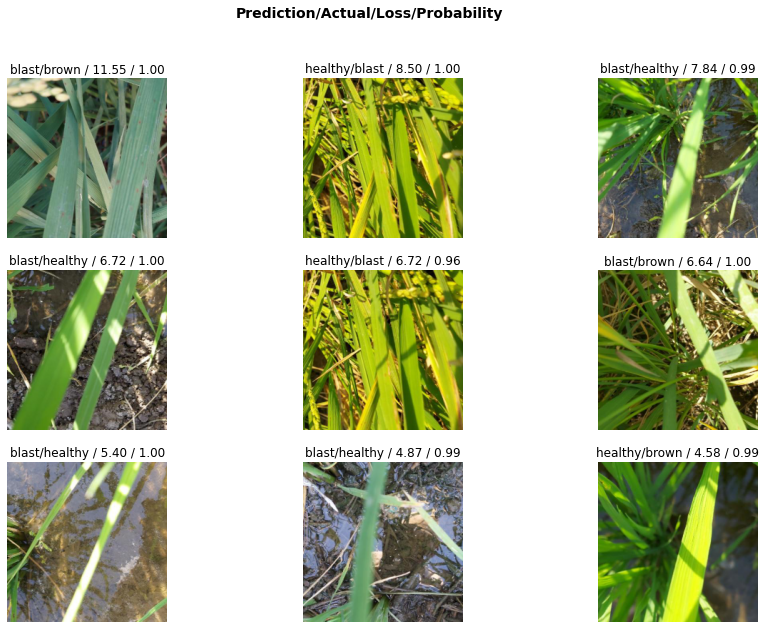

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

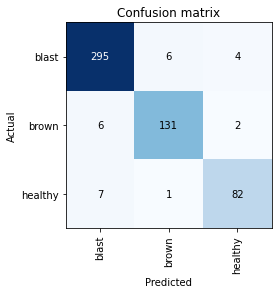

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
test = pd.read_csv('Test.csv')
test = test[~test.Image_id.str.contains('_rgn')] # Just the RGB images

In [ ]:
preds, _ = learn.get_preds(dl=dls.test_dl(test)) # Getting the predicted probabilities
preds

TensorBase([[9.9999e-01, 1.8412e-06, 8.7718e-06],
            [3.0114e-05, 9.9996e-01, 8.0025e-06],
            [5.1773e-03, 1.6477e-01, 8.3005e-01],
            ...,
            [4.8866e-01, 3.9535e-01, 1.1599e-01],
            [9.9838e-01, 8.5225e-04, 7.6666e-04],
            [8.9509e-02, 2.1580e-05, 9.1047e-01]])

In [ ]:
#learn.dls.vocab
#learn.fine_tune(10) 

In [ ]:
print(train_rgb.shape), print(test.shape)

(2670, 2)
(1145, 1)


(None, None)

In [ ]:
preds[0] 

TensorBase([9.9999e-01, 1.8412e-06, 8.7718e-06])

In [ ]:
submission = pd.DataFrame({'Image_id': test['Image_id']})
for i, label in enumerate(learn.dls.vocab):
  submission[label] = preds[:,i].numpy()
submission.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.999989,1.841225e-06,8.771807e-06
2,id_01hu05mtch.jpg,0.000030,9.999619e-01,8.002475e-06
4,id_030ln10ewn.jpg,0.005177,1.647742e-01,8.300484e-01
6,id_03z57m8xht.jpg,1.000000,1.847186e-07,2.577535e-07
8,id_04ngep1w4b.jpg,0.999864,1.213202e-04,1.460622e-05


In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
test.shape

(1145, 1)